This takes the saved results from ComparePipeline_Refined.ipynb and looks at the PCC by conditioning strength/rescaling & plots some of the results

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style.txt')
import os
import pandas as pd
import torch
import numpy as np
#import pickle

import sys
sys.path.insert(0,'../data_utils/')
from HiCDataset import HiCDataset

In [12]:
folder = './first_view_figs/'#_hic_embeddings/'

In [13]:
nbeads = 64
resolution = 20_000
exp_hic = HiCDataset()
rosetta_stone = {
    144:(1300000, '1', 3660000),
    200:(1300000, '1', 4780000),
    265:(1300000, '1', 6080000),
    330:(1300000, '1', 7380000),
    395:(1300000, '1', 8680000),
    460:(1300000, '1', 9980000),
    525:(1300000, '1', 11280000),
    590:(1300000, '1', 14320000),
    730:(1300000, '1', 17120000),
    795:(1300000, '1', 18420000),
    860:(1300000, '1', 19720000),
    1260:(1300000, '1', 27720000),
    1325:(1300000, '1', 29020000)
}
def get_hic_map(region_idx,rosetta_stone=rosetta_stone,exp_hic=exp_hic,nbeads=nbeads,resolution=resolution):
    _,chrom,start_idx = rosetta_stone[region_idx]
    return exp_hic.fetch(chrom=chrom,start=start_idx,stop=start_idx + nbeads*resolution)

In [14]:
def parse_filename(filename):

    filename = '.'.join(filename.split('/')[-1].split('.')[:-1])
    region_idx, cond_scale, rescaled_phi, milestone, chrom = filename.split('_')[:5]
    region_idx = int(region_idx)
    cond_scale = float(cond_scale)
    rescaled_phi = float(rescaled_phi)
    milestone = int(milestone)

    return chrom, region_idx, cond_scale, rescaled_phi, milestone

In [15]:
class Figures(pd.DataFrame):

    
    def __init__(self):
        super().__init__()
        attributes = {
            'Chromosome':[],
            'Region Index':[],
            'Guidance Strength':[],
            'Rescaling Strength':[],
            'Milestone':[],
            'Decay Rate':[],
            'Norm Hi-C':[],
            'fig':[],
            'ax':[],
            'im':[],
            'cbar':[],
            'best_r_c':[],
            'best_sigma':[],
            'best_pcc':[],
            'best_mse':[]
        }
        
        for i,(key,item) in enumerate(attributes.items()):
            self.insert(i,key,item,True)
    
    def load_from_folder(self,folder):
        
        files = os.listdir(folder)
        for file in files: 
            if 'unguided' in file:
                continue
            i = len(self)
            self.loc[i,self.__ordered_cap_keys] = parse_filename(file)
            data = pd.read_pickle(folder+'/'+file)
            data = {
                key:item if type(item)!= torch.Tensor else item.numpy() for key,item in data.items()
            }
            keys = [*data.keys()]
            #print(keys)
            #print([data[key] for key in keys])
            #print(self.loc[i,keys])
            self.loc[i,keys] = [data[key] for key in keys]
            plt.close(self.loc[i,'fig'])
            self.loc[i,'Decay Rate'] = 4 if 'quartic' in file else 3
            self.loc[i,'Norm Hi-C'] = 'norm_hic' in file
            del data, keys

        self.sort_values(self.__sort_order,ignore_index=True,inplace=True)

    @property
    def __cap_keys(self):
        #return ['Chromosome','Region Index','Guidance Strength','Rescaling Strength','Milestone']
        return [key for key in self.keys() if key[0].isupper()]

    @property
    def __ordered_cap_keys(self):
        return ['Chromosome','Region Index','Guidance Strength','Rescaling Strength','Milestone']

    @property
    def __sort_order(self):
        return ['Decay Rate','Chromosome','Region Index','Guidance Strength','Rescaling Strength','Milestone']

    @property
    def __ordered_uncap_keys(self):
        return ['fig','ax','im','cbar','best_r_c','best_sigma','best_pcc']
    
    def max_pcc(
        self,
        chroms=None,
        region_idxs=None,
        cond_scales=None,
        rescaled_phis=None,
        milestones=None,
        decay_rates=None,
        norm_hic=None
    ):
        
        idx = self.__parse_restrictions(chroms,region_idxs,cond_scales,rescaled_phis,milestones,decay_rates,norm_hic,use_mse=False)

        temp = self[idx]
        max_pcc = temp['best_pcc'].values.max()
        rows = temp[temp['best_pcc']==max_pcc]
        
        return rows.loc[:,self.__cap_keys], self.__return_figures(rows) #rows.loc[:,self.__ordered_uncap_keys].values

    def min_mse(
        self,
        chroms=None,
        region_idxs=None,
        cond_scales=None,
        rescaled_phis=None,
        milestones=None,
        decay_rates=None,
        norm_hic=None
    ):
        
        idx = self.__parse_restrictions(chroms,region_idxs,cond_scales,rescaled_phis,milestones,decay_rates,norm_hic,use_pcc=False)

        temp = self[idx]
        min_mse = temp['best_mse'].values.min()
        rows = temp[temp['best_mse']==min_mse]
        
        return rows.loc[:,self.__cap_keys], self.__return_figures(rows) #rows.loc[:,self.__ordered_uncap_keys].values

    def __return_figures(self,rows):
        if len(rows) == 0:
            return None
        if len(rows) == 1:
            return rows.fig.values[0]
        return [*rows.fig.values]

    def __parse_restriction(self,key,restriction):
        if restriction is None:
            return np.ones(len(self),dtype=bool) # All are valid

        if type(restriction) in [bool, str, int, float, type(None)]:
            restriction = [restriction]
            
        idx_to_keep = np.zeros(len(self),dtype=bool)
        for r in restriction:
            idx_to_keep|= self[key] == r

        return idx_to_keep

    def __parse_restrictions(self,chroms,region_idxs,cond_scales,rescaled_phis,milestones,decay_rates,norm_hic,use_pcc=True,use_mse=True):
        if not use_pcc and not use_mse:
            return np.zeros(len(self),dtype=bool)
        elif use_pcc and use_mse:
            idx_to_keep = np.ones(len(self),dtype=bool)
        elif use_pcc:
            idx_to_keep = self.best_pcc.notnull().values
        else:
            idx_to_keep = self.best_mse.notnull().values

        if norm_hic is not None:
            if norm_hic:
                idx_to_keep&= self['Norm Hi-C'].values.astype(bool)
            else:
                idx_to_keep&= ~self['Norm Hi-C'].values.astype(bool)
            
        to_check = [
            ('Chromosome',chroms),
            ('Region Index',region_idxs),
            ('Guidance Strength',cond_scales),
            ('Rescaling Strength',rescaled_phis),
            ('Milestone',milestones),
            ('Decay Rate',decay_rates),
        ]
        
        for key,restriction in to_check:
            idx_to_keep&= self.__parse_restriction(key,restriction)

        return idx_to_keep
            
        
        
        
        
        
    

In [39]:
figs = Figures()
figs.load_from_folder(folder)

In [19]:
#info,fig = figs.min_mse(milestones=120,decay_rates=None)#.fig.values[0]
#print(info)
#fig

In [8]:
info,fig = figs.max_pcc(milestones=120,decay_rates=3)#.fig.values[0]
print(info)
fig

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
info,fig = figs.min_mse(milestones=120,region_idxs=144,decay_rates=3)
print(info)
fig

In [ ]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=330,decay_rates=3)
print(info)
fig

In [ ]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=395,decay_rates=3)
print(info)
fig

In [ ]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=460,decay_rates=3)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1557          1         395.0                1.0                 0.0   

      Milestone  Decay Rate Norm Hi-C  
1557      120.0         4.0     False  


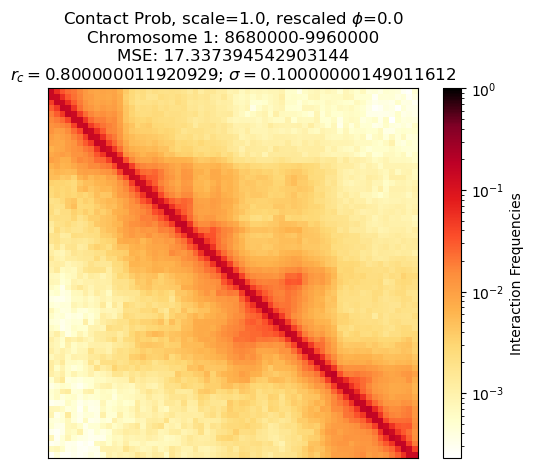

In [51]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=None,decay_rates=4)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1143          1         200.0                0.5                 0.9   

      Milestone  Decay Rate Norm Hi-C  
1143      120.0         4.0     False  


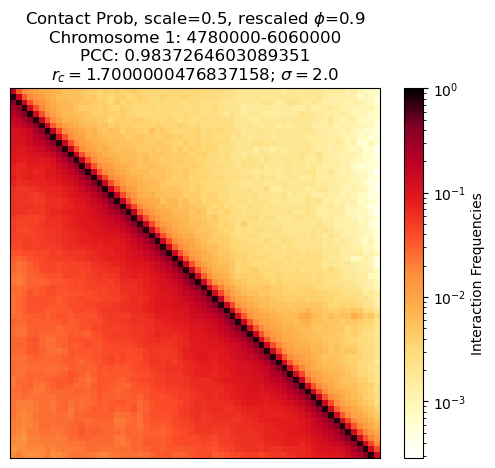

In [118]:
info,fig = figs.max_pcc(milestones=120,cond_scales=None,region_idxs=None,decay_rates=4)
print(info)
fig

#### Every region at decay rate 3

In [163]:
milestone=120
decay_rate = 3
def mini_get_info_fig(region_idx=None,milestones=milestone,cond_scales=None,decay_rate=decay_rate,norm_hic=False):
    return figs.min_mse(milestones=milestones,cond_scales=cond_scales,region_idxs=region_idx,decay_rates=decay_rate,norm_hic=norm_hic)
    #return figs.max_pcc(milestones=milestones,cond_scales=cond_scales,region_idxs=region_idx,decay_rates=decay_rate,norm_hic=norm_hic)

In [164]:
figs[(figs['Decay Rate']==decay_rate)&(~pd.isna(figs['best_mse']))&(figs['Milestone']==milestone)]['Region Index'].unique()

array([ 144.,  200.,  265.,  330.,  395.,  460.,  525.,  590.,  730.,
        795.,  860., 1260., 1325.])

  Chromosome  Region Index  Guidance Strength  Rescaling Strength  Milestone  \
9          1         144.0                0.5                 0.2      120.0   

   Decay Rate Norm Hi-C  
9         3.0     False  


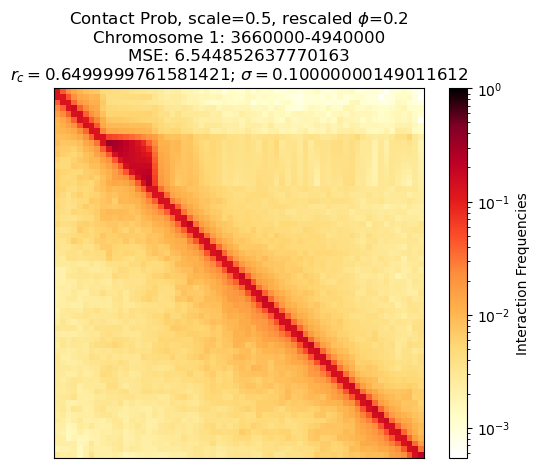

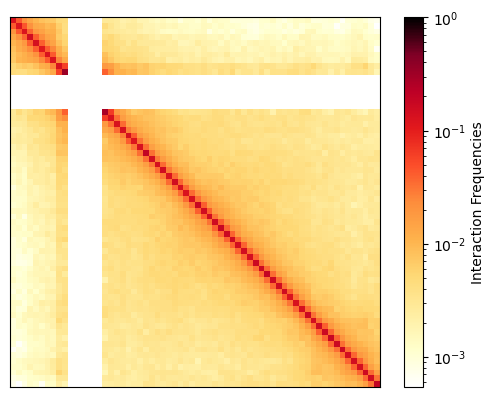

In [165]:
info,fig = mini_get_info_fig(144)
print(info)
# for reference, also plotting hic map without interpolating nan's
get_hic_map(144).plot()
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
151          1         200.0                0.5                 0.6   

     Milestone  Decay Rate Norm Hi-C  
151      120.0         3.0     False  


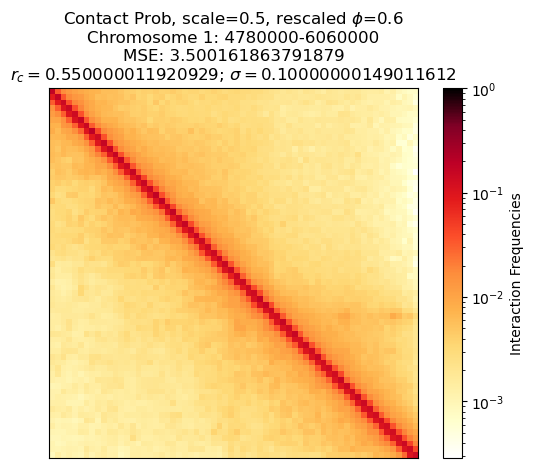

In [166]:
info,fig = mini_get_info_fig(200)
print(info)
# for reference, also plotting hic map without interpolating nan's
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
219          1         265.0                1.0                 0.0   

     Milestone  Decay Rate Norm Hi-C  
219      120.0         3.0     False  


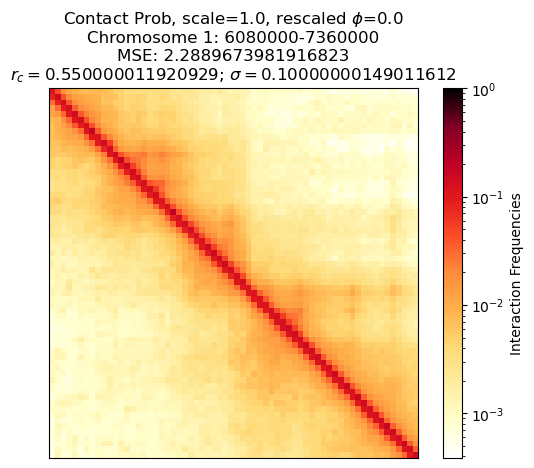

In [167]:
info,fig = mini_get_info_fig(265)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
287          1         330.0                1.5                 0.3   

     Milestone  Decay Rate Norm Hi-C  
287      120.0         3.0     False  


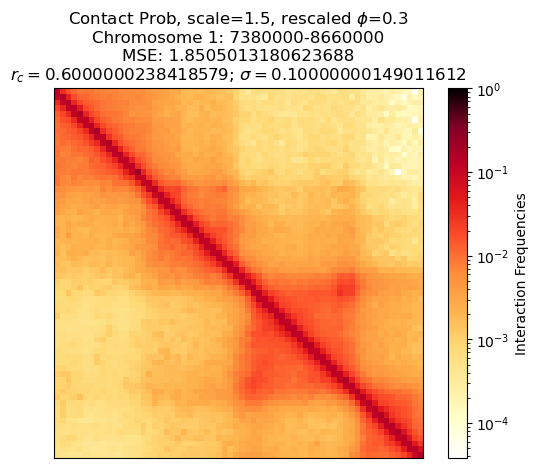

In [168]:
info,fig = mini_get_info_fig(330)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
454          1         395.0                1.5                 0.3   

     Milestone  Decay Rate Norm Hi-C  
454      120.0         3.0     False  


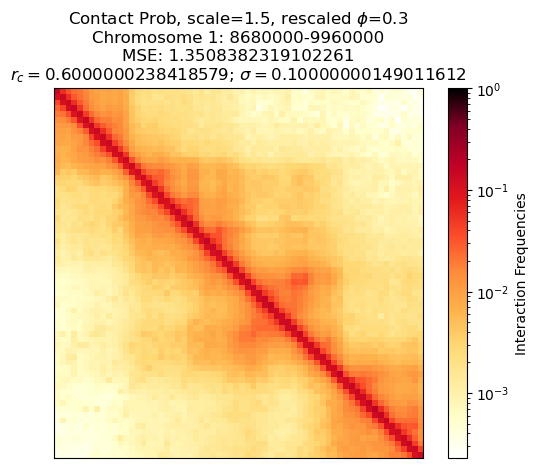

In [169]:
info,fig = mini_get_info_fig(395)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
554          1         460.0                1.5                 0.9   

     Milestone  Decay Rate Norm Hi-C  
554      120.0         3.0     False  


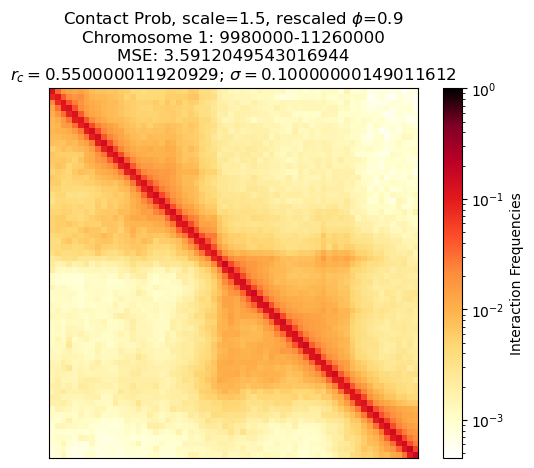

In [170]:
info,fig = mini_get_info_fig(460)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
599          1         525.0                1.5                 0.2   

     Milestone  Decay Rate Norm Hi-C  
599      120.0         3.0     False  


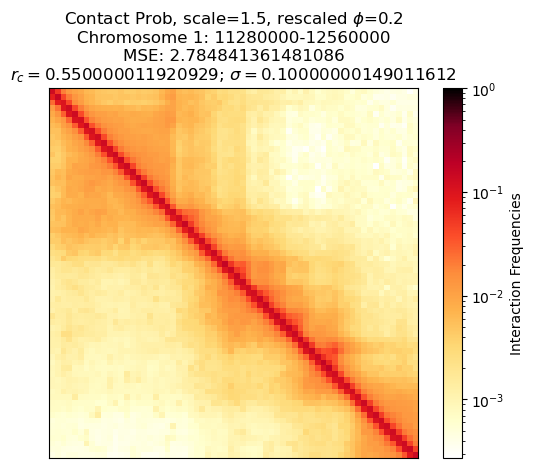

In [171]:
info,fig = mini_get_info_fig(525)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
634          1         590.0                0.5                 0.1   

     Milestone  Decay Rate Norm Hi-C  
634      120.0         3.0     False  


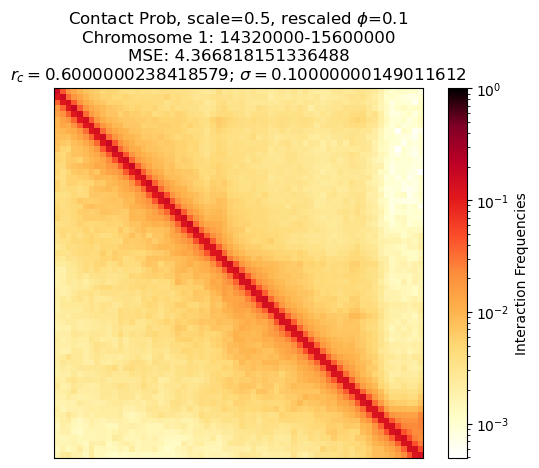

In [172]:
info,fig = mini_get_info_fig(590)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
713          1         730.0                1.5                 0.0   

     Milestone  Decay Rate Norm Hi-C  
713      120.0         3.0     False  


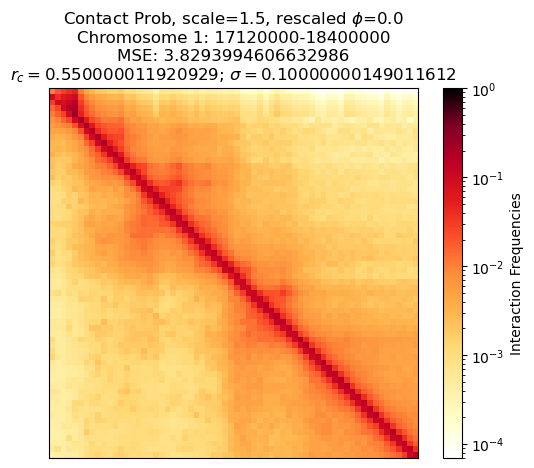

In [173]:
info,fig = mini_get_info_fig(730)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
780          1         795.0                1.5                 0.4   

     Milestone  Decay Rate Norm Hi-C  
780      120.0         3.0     False  


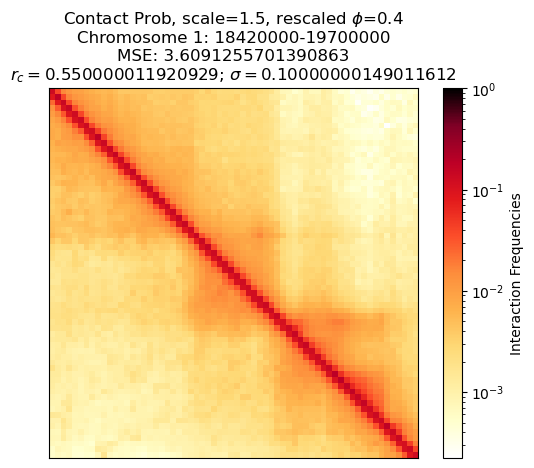

In [174]:
info,fig = mini_get_info_fig(795)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
836          1         860.0                1.5                 0.3   

     Milestone  Decay Rate Norm Hi-C  
836      120.0         3.0     False  


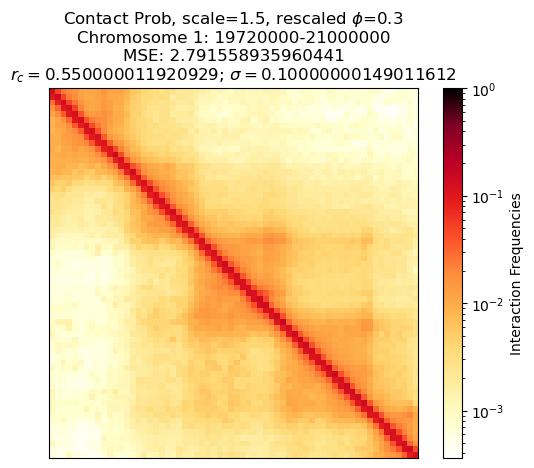

In [175]:
info,fig = mini_get_info_fig(860)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
889          1        1260.0                1.5                 0.0   

     Milestone  Decay Rate Norm Hi-C  
889      120.0         3.0     False  


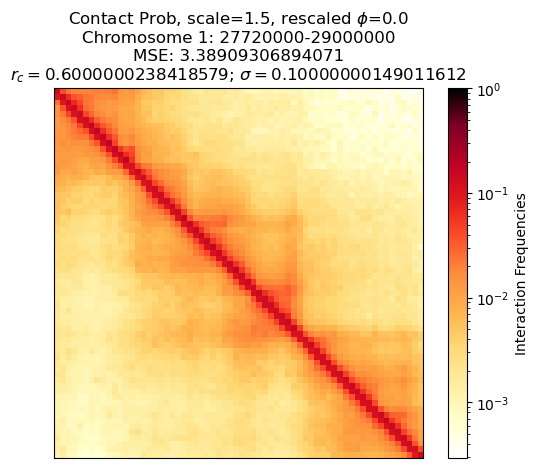

In [176]:
info,fig = mini_get_info_fig(1260)
print(info)
fig

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
962          1        1325.0                1.5                 0.8   

     Milestone  Decay Rate Norm Hi-C  
962      120.0         3.0     False  


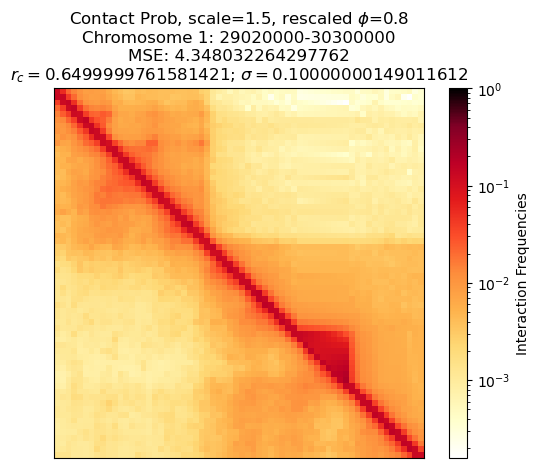

In [177]:
info,fig = mini_get_info_fig(1325)
print(info)
fig

#### Every region at decay rate 4

In [178]:
milestone=120
decay_rate = 4
def mini_get_info_fig(region_idx=None,milestones=milestone,cond_scales=None,decay_rate=decay_rate,norm_hic=False):
    return figs.min_mse(milestones=milestones,cond_scales=cond_scales,region_idxs=region_idx,decay_rates=decay_rate,norm_hic=norm_hic)

In [179]:
figs[(figs['Decay Rate']==decay_rate)&(~pd.isna(figs['best_mse']))&(figs['Milestone']==milestone)]['Region Index'].unique()

array([ 144.,  200.,  265.,  330.,  395.,  460.,  525.,  590.,  730.,
        795.,  860., 1260., 1325.])

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
982          1         144.0                0.5                 0.0   

     Milestone  Decay Rate Norm Hi-C  
982      120.0         4.0     False  


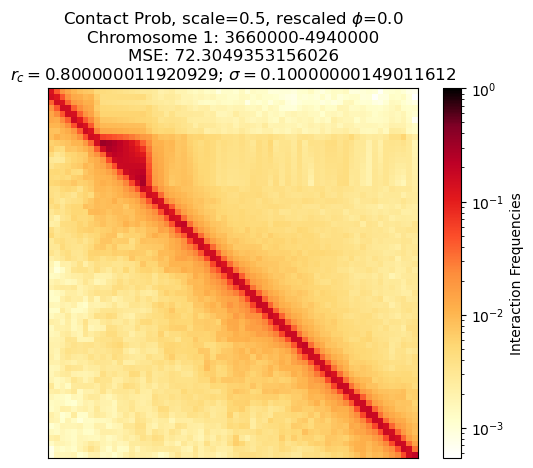

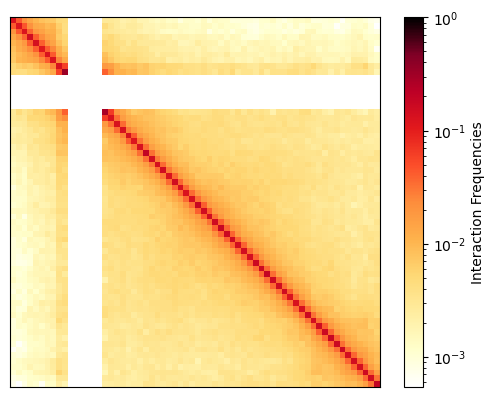

In [180]:
info,fig = mini_get_info_fig(144)
print(info)
# for reference, also plotting hic map without interpolating nan's
get_hic_map(144).plot()
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1329          1         265.0                2.0                 0.4   

      Milestone  Decay Rate Norm Hi-C  
1329      120.0         4.0     False  


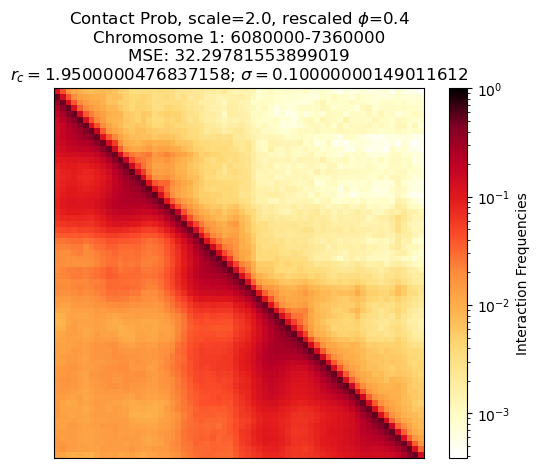

In [181]:
info,fig = mini_get_info_fig(265)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1475          1         330.0                2.5                 0.0   

      Milestone  Decay Rate Norm Hi-C  
1475      120.0         4.0     False  


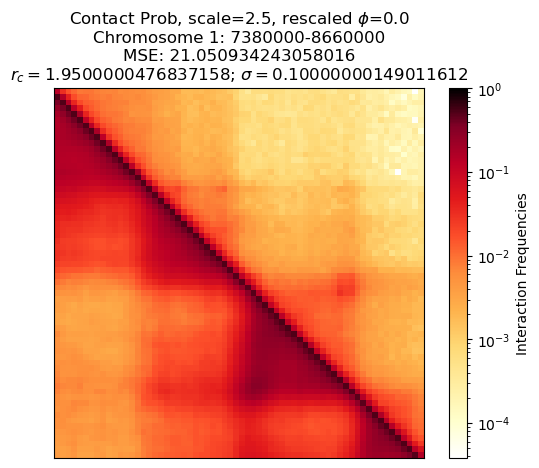

In [182]:
info,fig = mini_get_info_fig(330)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1557          1         395.0                1.0                 0.0   

      Milestone  Decay Rate Norm Hi-C  
1557      120.0         4.0     False  


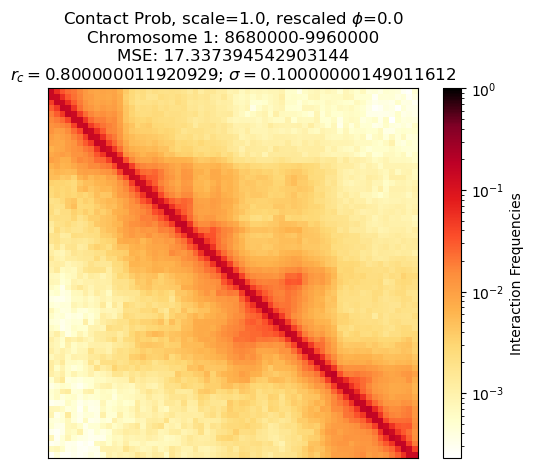

In [183]:
info,fig = mini_get_info_fig(395)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1705          1         460.0                0.5                 0.5   

      Milestone  Decay Rate Norm Hi-C  
1705      120.0         4.0     False  


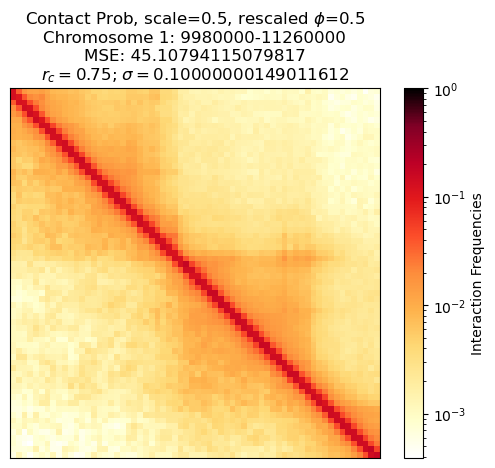

In [184]:
info,fig = mini_get_info_fig(460)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1887          1         525.0                2.0                 0.0   

      Milestone  Decay Rate Norm Hi-C  
1887      120.0         4.0     False  


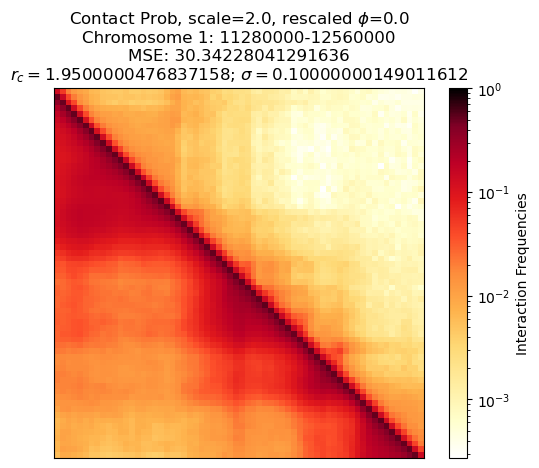

In [185]:
info,fig = mini_get_info_fig(525)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
1949          1         590.0                0.5                 0.8   

      Milestone  Decay Rate Norm Hi-C  
1949      120.0         4.0     False  


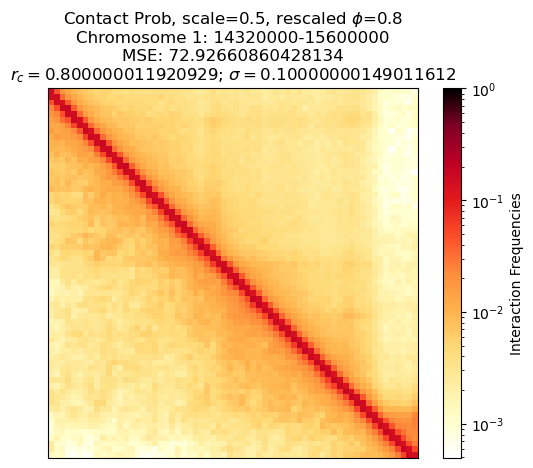

In [186]:
info,fig = mini_get_info_fig(590)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2101          1         730.0                2.0                 0.8   

      Milestone  Decay Rate Norm Hi-C  
2101      120.0         4.0     False  


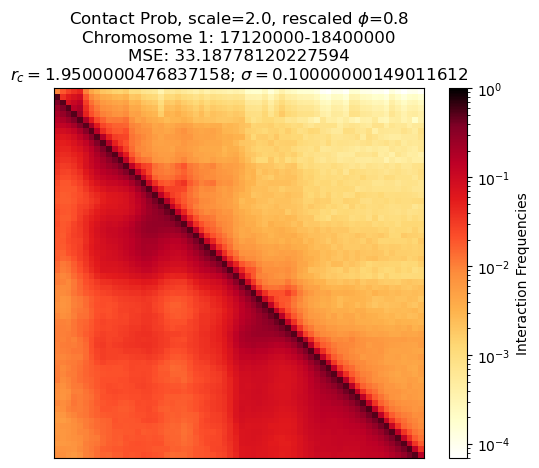

In [187]:
info,fig = mini_get_info_fig(730)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2177          1         795.0                2.0                 0.3   

      Milestone  Decay Rate Norm Hi-C  
2177      120.0         4.0     False  


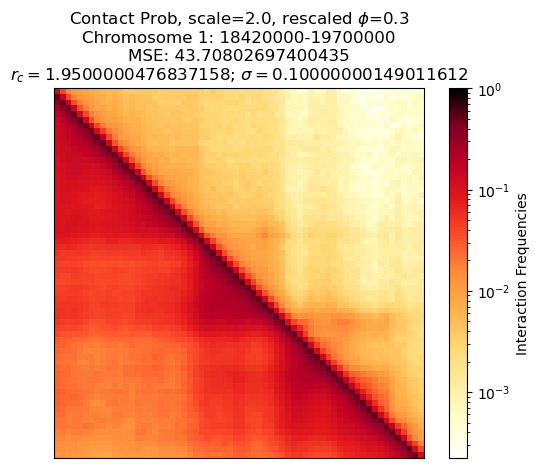

In [188]:
info,fig = mini_get_info_fig(795)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2218          1         860.0                0.5                 0.8   

      Milestone  Decay Rate Norm Hi-C  
2218      120.0         4.0     False  


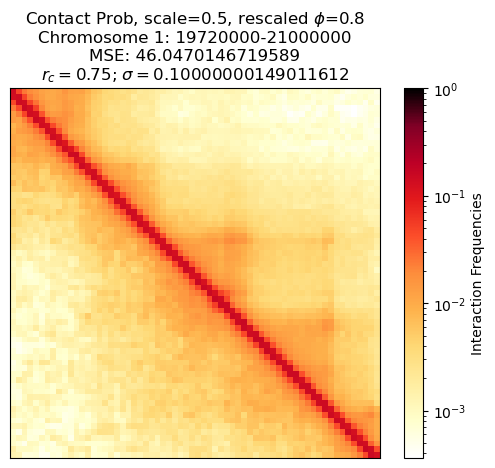

In [189]:
info,fig = mini_get_info_fig(860)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2309          1        1260.0                1.0                 0.0   

      Milestone  Decay Rate Norm Hi-C  
2309      120.0         4.0     False  


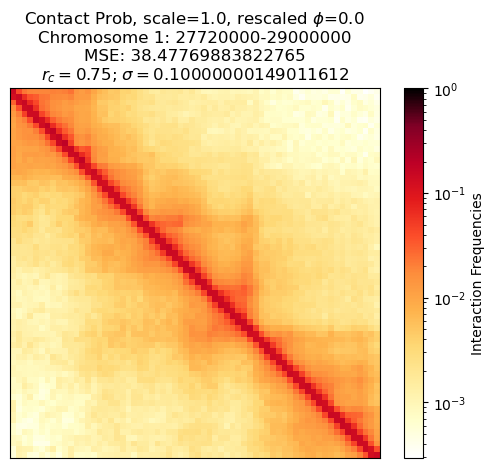

In [190]:
info,fig = mini_get_info_fig(1260)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2384          1        1325.0                1.5                 0.8   

      Milestone  Decay Rate Norm Hi-C  
2384      120.0         4.0     False  


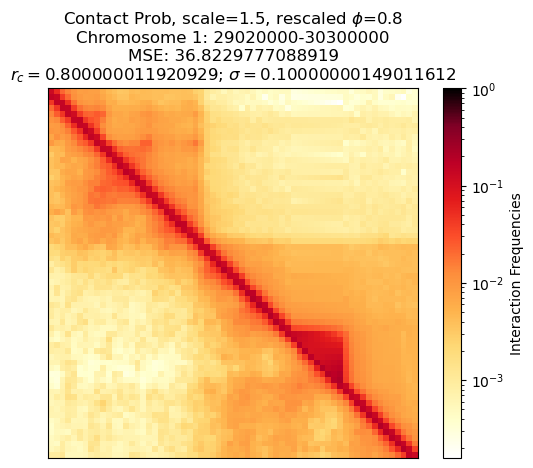

In [191]:
info,fig = mini_get_info_fig(1325)
print(info)
fig

#### Having normalized Hi-C data!

In [147]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=None,decay_rates=4,norm_hic=True)
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
984           1         144.0                0.5                 0.0   
987           1         144.0                0.5                 0.1   
991           1         144.0                0.5                 0.2   
997           1         144.0                0.5                 0.3   
998           1         144.0                0.5                 0.4   
...         ...           ...                ...                 ...   
1907          1         525.0                2.0                 0.5   
1910          1         525.0                2.0                 0.6   
1917          1         525.0                2.0                 0.7   
1921          1         525.0                2.0                 0.8   
1923          1         525.0                2.0                 0.9   

      Milestone  Decay Rate Norm Hi-C  
984       120.0         4.0      True  
987       120.0         4.0      True  
991       120.0

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2

In [ ]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=None,decay_rates=3,norm_hic=True)
print(info)
fig

#### Having normalized Hi-C data!

In [ ]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=None,decay_rates=4,norm_hic=True)
print(info)
fig

In [ ]:
info,fig = figs.min_mse(milestones=120,cond_scales=None,region_idxs=None,decay_rates=3,norm_hic=True)
print(info)
fig

In [ ]:
asdf

    Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
426          1         395.0                3.0                 0.5   

     Milestone  Decay Rate  
426       51.0         3.0  


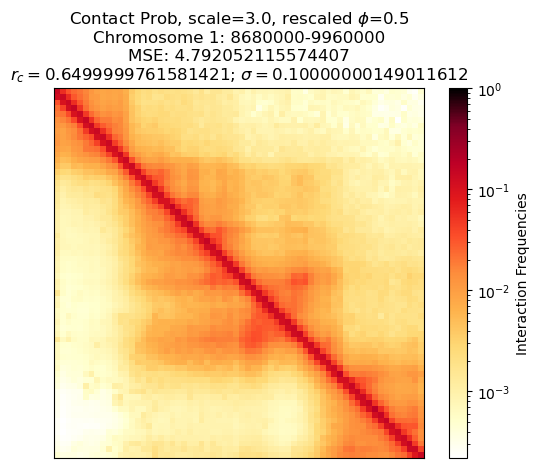

In [61]:
info,fig = figs.min_mse(milestones=51,cond_scales=3.,rescaled_phis=0.5,decay_rates=3)
print(info)
fig

In [152]:
def tanh_cutoff(r,r_c,sigma):

    mask = r < r_c
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**3

    return r 

In [153]:
def tanh_cutoff_original(r,r_c,sigma):

    mask = r < r_c
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4

    return r 

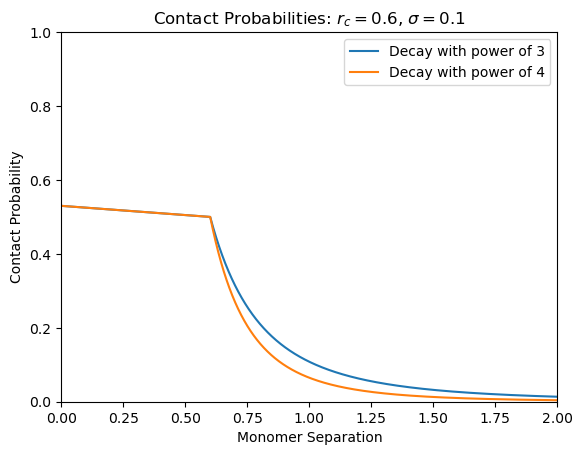

In [155]:
xrange = [0,2]
r_c=.6
sigma=.1
x = torch.arange(xrange[0],xrange[1],.001)
y = tanh_cutoff(x.clone(),r_c,sigma)
y1 = tanh_cutoff_original(x.clone(),r_c,sigma)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y,label='Decay with power of 3')
ax.plot(x,y1,label='Decay with power of 4')
ax.set_ylim([0,1])
ax.set_xlim(xrange)
ax.set_xlabel("Monomer Separation")
ax.set_ylabel("Contact Probability")
ax.set_title(f"Contact Probabilities: $r_c={r_c}$, $\\sigma={sigma}$")
ax.legend()

#### X Chromosome 

In [32]:
figs[figs['Chromosome']=='X']['Region Index'].unique()

array([100., 381., 445., 553., 610., 965.])

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2363          X         100.0                1.5                 0.2   

      Milestone  Decay Rate Norm Hi-C  
2363      120.0         3.0     False  


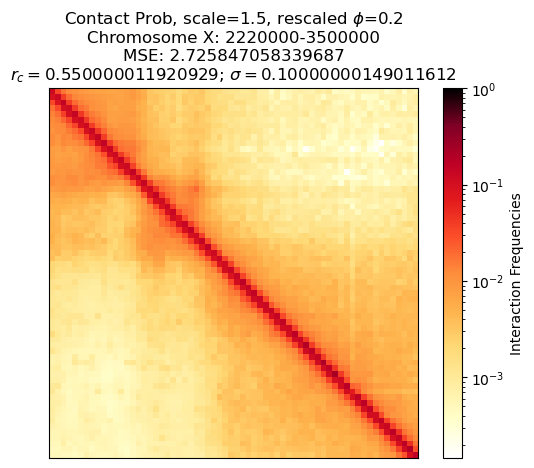

In [42]:
figs[figs['Chromosome']=='X']['Region Index'].unique()
info,fig = figs.min_mse(milestones=120,chroms='X',region_idxs=100)#decay_rates=3)#.fig.values[0]
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2464          X         381.0                1.5                 0.8   

      Milestone  Decay Rate Norm Hi-C  
2464      120.0         3.0     False  


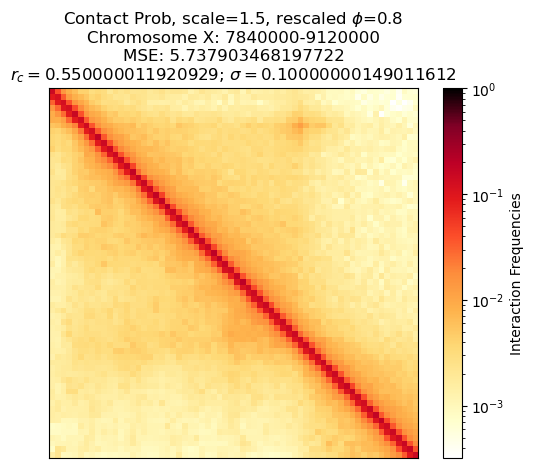

In [43]:
figs[figs['Chromosome']=='X']['Region Index'].unique()
info,fig = figs.min_mse(milestones=120,chroms='X',region_idxs=381)#decay_rates=3)#.fig.values[0]
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2547          X         445.0                0.5                 0.7   

      Milestone  Decay Rate Norm Hi-C  
2547      120.0         3.0     False  


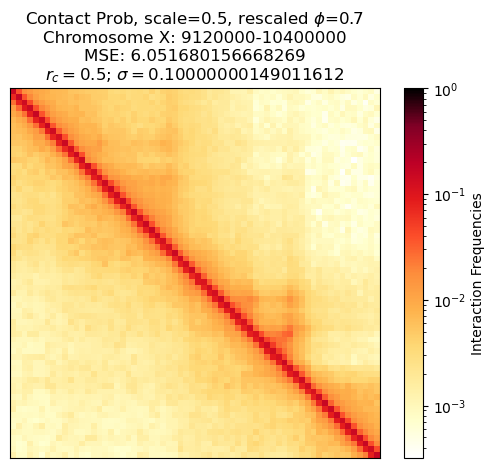

In [44]:
figs[figs['Chromosome']=='X']['Region Index'].unique()
info,fig = figs.min_mse(milestones=120,chroms='X',region_idxs=445)#decay_rates=3)#.fig.values[0]
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2637          X         553.0                0.5                 0.3   

      Milestone  Decay Rate Norm Hi-C  
2637      120.0         3.0     False  


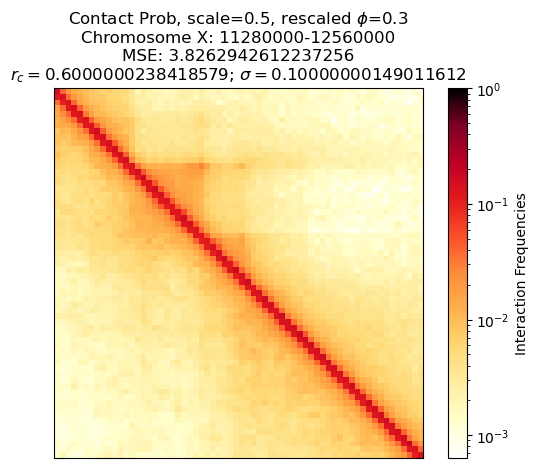

In [45]:
figs[figs['Chromosome']=='X']['Region Index'].unique()
info,fig = figs.min_mse(milestones=120,chroms='X',region_idxs=553)#decay_rates=3)#.fig.values[0]
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2740          X         610.0                1.5                 0.0   

      Milestone  Decay Rate Norm Hi-C  
2740      120.0         3.0     False  


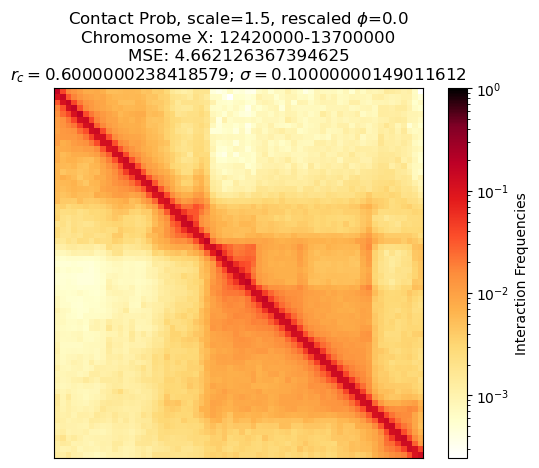

In [46]:
figs[figs['Chromosome']=='X']['Region Index'].unique()
info,fig = figs.min_mse(milestones=120,chroms='X',region_idxs=610)#decay_rates=3)#.fig.values[0]
print(info)
fig

     Chromosome  Region Index  Guidance Strength  Rescaling Strength  \
2823          X         965.0                0.5                 0.0   

      Milestone  Decay Rate Norm Hi-C  
2823      120.0         3.0     False  


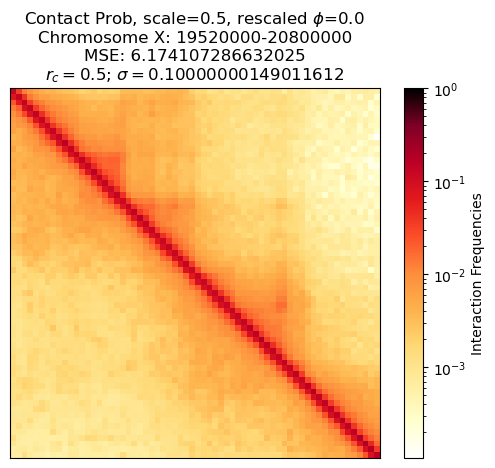

In [49]:
figs[figs['Chromosome']=='X']['Region Index'].unique()
info,fig = figs.min_mse(milestones=120,chroms='X',region_idxs=965)#decay_rates=3)#.fig.values[0]
print(info)
fig

In [58]:
figs[
    (figs['Norm Hi-C']==True)&
    (figs['Chromosome']=='1')&
    (figs['Region Index']==330)&
    (~pd.isna(figs['best_mse']))
]['best_mse'].min()

inf

In [1]:
import mdtraj as md

ModuleNotFoundError: No module named 'mdtraj'